In [36]:
import numpy as np
import pandas as pd
import datetime as dt

import praw

import re
import string

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

from gensim import corpora, models, similarities, matutils
import logging

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
np.set_printoptions(suppress=True)

In [37]:
sneakers = pd.read_csv('sneaker_topmonth_withnames.csv')
sneakers2 = pd.read_csv('sneaker_topweek_withnames.csv')

In [38]:
#concatenate
frames = [sneakers, sneakers2]
new_df = pd.concat(frames)

In [39]:
#cleaning

words2remove = [' www ',' com ',' http ',' jpeg ',' https ',' jpg ',' pjpg ',' redd ',
                     ' html ',' got ',' don '
                     ' pair ',' really ',' velook ',' think ',' know ',' like ',' just ',' ha ',
                     ' going ',' probably ',' looks ',' lol ',' actually ',' lot ',' ll ',
                     ' ner ',' sure ',' ery ',' did ',' ha ',' ve ',' sneakerfits ',' grailedlistings ',
                     ' wiki ',' wikipedia ',' org ',' en ',' pedia ', ' message ', ' compose ', ' ve ', "i've"]

patt = re.compile(r'|'.join(words2remove))

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_words = lambda x: re.sub(patt,' ', x)

In [40]:
def replace_slang(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["i'd", "you'd", "we'd","they'd", "i'll", "you'll", "we'll", "they'll", "i'm",
                  "y'all", "you're", "we're", "they're", "i've", "you've", "we've", "they've", "didn't", "shouldn't",
                 "couldn't", "wouldn't", "won't", "can't", "mustn't", "ain't", "isn't", "that's", "doesn't", "it'd",
                  "it'll", "/month", "/ month", "don't", "there's", "it's", "imo"]
    
    replace_with = ["i would", "you would", "we would", "they would", "i will", "you will", "we will", "they will",
                   "i am", "you all", "you are", "we are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not", "is not",
                   "that is", "does not", "it would", "it will", "per month", "per month", "do not", "there is", "it is",
                   "in my opinion"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

def remove_urls(s):
    s = re.sub("http[^\s]+", " ", s)
    s = re.sub("https[^\s]+", " ", s)
    s = re.sub("[^\s]+\.us[^\s]+", " ", s)
    s = re.sub("[^\s]+\.co.uk[^\s]+", " ", s)
    s = re.sub("[^\s]+\.com[^\s]+", " ", s)
    s = re.sub(" +", " ", s)
    return s

# remove apostrophes
def remove_apostrophe(s):
    s = re.sub("'", '',s)
    s = re.sub("\"", "", s)
    s = re.sub("\*", " ", s)
    s = re.sub("&gt;", " ", s)
    s = re.sub("&gt", " ", s)
    s = re.sub("&amp;#37;", "%", s)
    s = re.sub("&amp;", "&", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

def replace_slang_again(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["id", "youd", "theyd", "youll", "they'll", "im",
                  "yall", "youre", "theyre", "ive", "youve", "weve", "theyve", "didnt", "shouldnt",
                 "couldnt", "wouldnt", "wont", "cant", "mustnt", "aint", "isnt", "thats", "doesnt", "itd", "ill", "w/ live",
                 "w/live", "w/no", "itll", "/ month", "/month", "w/ no", "dont", "theres", "at&amp;t", "its"]
    
    replace_with = ["i would", "you would", "they would", "you will", "they will",
                   "i am", "you all", "you are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not",
                   "is not", "that is", "does not", "it would", "i will", "with live", "with live", "with no", "it will",
                   "per month", "per month", "with no", "do not", "there is", "att" ,"it is"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

def remove_parantheses(s):
    s = re.sub("\(", ' ',s)
    s = re.sub("\[", ' ',s)
    s = re.sub("]", ' ',s)
    s = re.sub("\|", ' ', s)
    s = re.sub("\)", " ", s)
    s = re.sub("\^", " ", s)
    s = re.sub("#", " ", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

def fullstop_space(s):
    s = re.sub(r'(?<=[.,])(?=[^\s\.[0-9]])', r' ', s)
    return s


In [41]:
new_df['clean_comments'] = new_df['comments'].map(alphanumeric).map(punc_lower)

new_df['clean_comments'] = new_df['clean_comments'].map(remove_words)
new_df['clean_comments'] = new_df['clean_comments'].map(replace_slang)
new_df['clean_comments'] = new_df['clean_comments'].map(replace_slang_again)
new_df['clean_comments'] = new_df['clean_comments'].map(remove_urls)
new_df['clean_comments'] = new_df['clean_comments'].map(remove_apostrophe)
new_df['clean_comments'] = new_df['clean_comments'].map(remove_parantheses)
new_df['clean_comments'] = new_df['clean_comments'].map(fullstop_space)

In [42]:
new_df['comment_length'] = new_df.clean_comments.apply(lambda x: len(x))

In [43]:
new_df.shape

(31946, 7)

In [44]:
new_df = new_df.dropna()

In [45]:
new_df.shape

(31654, 7)

In [46]:
#fix date
def get_date(created):
    return dt.datetime.fromtimestamp(created)

_timestamp = new_df["date"].apply(get_date)

new_df = new_df.assign(timestamp = _timestamp)

In [47]:
# remove short comments
data = new_df[new_df['comment_length'] > 20]

In [48]:
data.shape

(22638, 8)

## Lemmatizing

In [49]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import WhitespaceTokenizer


nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxwellstaley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
data['tokens'] = data.clean_comments.apply(nltk.word_tokenize)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
wnl = WordNetLemmatizer()
def lemmatize(s):
    s = [wnl.lemmatize(word) for word in s]
    return s
    

In [52]:
data['lem_text'] = data.tokens.apply(lambda x: lemmatize(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

data['lem_strings'] = data.lem_text.apply(TreebankWordDetokenizer().detokenize)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
data.head()

,header,comments,date,score,name,clean_comments,comment_length,timestamp,tokens,lem_text,lem_strings
0,Lost my UltraBoost😒,Imagine walking down the sidewalk and a UB fal...,1.572347e+09,1653,fathertocarter,imagine walking down the sidewalk and a ub fal...,90,2019-10-29 04:10:18,"[imagine, walking, down, the, sidewalk, and, a...","[imagine, walking, down, the, sidewalk, and, a...",imagine walking down the sidewalk and a ub fal...
1,Lost my UltraBoost😒,I’ve seen the movie “holes” to know I shouldn’...,1.572347e+09,1147,califas_foo,i’ve seen the movie “holes” to i shouldn’t pic...,55,2019-10-29 04:10:18,"[i, ’, ve, seen, the, movie, “, holes, ”, to, ...","[i, ’, ve, seen, the, movie, “, hole, ”, to, i...",i ’ ve seen the movie “ hole ” to i shouldn ’ ...
2,Lost my UltraBoost😒,"Imagine the roller coaster of emotions. ""Oh lo...",1.572347e+09,134,xyrgh,imagine the roller coaster of emotions oh look...,137,2019-10-29 04:10:18,"[imagine, the, roller, coaster, of, emotions, ...","[imagine, the, roller, coaster, of, emotion, o...",imagine the roller coaster of emotion oh look ...
3,Lost my UltraBoost😒,would the shoe like explode or just bounce? th...,1.572347e+09,57,FIFAPLAYAH,would the shoe explode or bounce the real boos...,52,2019-10-29 04:10:18,"[would, the, shoe, explode, or, bounce, the, r...","[would, the, shoe, explode, or, bounce, the, r...",would the shoe explode or bounce the real boos...
4,Lost my UltraBoost😒,So this is why random shoes are on the side of...,1.572347e+09,8,jomelle,so this is why random shoes are on the side of...,73,2019-10-29 04:10:18,"[so, this, is, why, random, shoes, are, on, th...","[so, this, is, why, random, shoe, are, on, the...",so this is why random shoe are on the side of ...


In [55]:
data.lem_strings = data.lem_strings.map(remove_apostrophe)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [56]:
data.head()

,header,comments,date,score,name,clean_comments,comment_length,timestamp,tokens,lem_text,lem_strings
0,Lost my UltraBoost😒,Imagine walking down the sidewalk and a UB fal...,1.572347e+09,1653,fathertocarter,imagine walking down the sidewalk and a ub fal...,90,2019-10-29 04:10:18,"[imagine, walking, down, the, sidewalk, and, a...","[imagine, walking, down, the, sidewalk, and, a...",imagine walking down the sidewalk and a ub fal...
1,Lost my UltraBoost😒,I’ve seen the movie “holes” to know I shouldn’...,1.572347e+09,1147,califas_foo,i’ve seen the movie “holes” to i shouldn’t pic...,55,2019-10-29 04:10:18,"[i, ’, ve, seen, the, movie, “, holes, ”, to, ...","[i, ’, ve, seen, the, movie, “, hole, ”, to, i...",i ’ ve seen the movie “ hole ” to i shouldn ’ ...
2,Lost my UltraBoost😒,"Imagine the roller coaster of emotions. ""Oh lo...",1.572347e+09,134,xyrgh,imagine the roller coaster of emotions oh look...,137,2019-10-29 04:10:18,"[imagine, the, roller, coaster, of, emotions, ...","[imagine, the, roller, coaster, of, emotion, o...",imagine the roller coaster of emotion oh look ...
3,Lost my UltraBoost😒,would the shoe like explode or just bounce? th...,1.572347e+09,57,FIFAPLAYAH,would the shoe explode or bounce the real boos...,52,2019-10-29 04:10:18,"[would, the, shoe, explode, or, bounce, the, r...","[would, the, shoe, explode, or, bounce, the, r...",would the shoe explode or bounce the real boos...
4,Lost my UltraBoost😒,So this is why random shoes are on the side of...,1.572347e+09,8,jomelle,so this is why random shoes are on the side of...,73,2019-10-29 04:10:18,"[so, this, is, why, random, shoes, are, on, th...","[so, this, is, why, random, shoe, are, on, the...",so this is why random shoe are on the side of ...


## Word Vectorization

In [57]:
sent = [row.split(',') for row in data['clean_comments']]

In [58]:
from gensim.models import Word2Vec
model = Word2Vec([phrase[0].split(' ') for phrase in sent], min_count=1,size= 50,workers=-1, window =5, sg = 1)

In [59]:
def get_similar(word, model = model):
    return model.wv.most_similar(word)

get_similar('nike')

[('notion', 0.5204094648361206),
 ('hoy', 0.47121718525886536),
 ('poster', 0.46678802371025085),
 ('cm', 0.46167850494384766),
 ('dent', 0.4557863473892212),
 ('raffles', 0.4404211640357971),
 ('shaqnosis', 0.43639421463012695),
 ('obsessed', 0.43079322576522827),
 ('product', 0.42796313762664795),
 ('westworld', 0.4259392321109772)]

In [60]:
get_similar('adidas')

[('symbol', 0.5716671943664551),
 ('aspen', 0.5616318583488464),
 ('keeps', 0.5496439933776855),
 ('maniere', 0.5473777055740356),
 ('interference', 0.5171091556549072),
 ('delivery', 0.5086416006088257),
 ('publicize', 0.4696078896522522),
 ('mans', 0.4682192802429199),
 ('ds', 0.4633861184120178),
 ('immortalized', 0.45389777421951294)]

In [61]:
get_similar('reebok')

[('yoooooooooooooooooooooo', 0.5091109275817871),
 ('engineering', 0.5029495358467102),
 ('wp', 0.4967765510082245),
 ('dudes', 0.47967728972435),
 ('itself', 0.4767339825630188),
 ('extras', 0.47344452142715454),
 ('largely', 0.455054372549057),
 ('bernie', 0.4539719223976135),
 ('comin’', 0.45148828625679016),
 ('scraping', 0.4510604739189148)]

In [62]:
from sklearn.decomposition import PCA

In [177]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0005, y+0.0005, word)
    plt.title('Word Vectors in 2D Space Using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



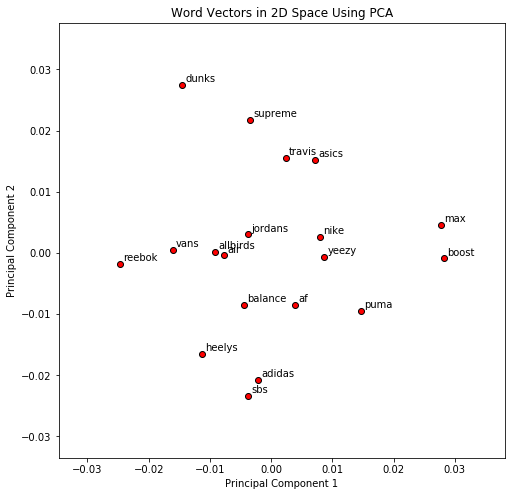

In [178]:
words = ['nike', 'adidas', 'yeezy', 'boost', 'vans', 'asics', 'puma', 'jordans', 'sbs', 'air', 'max', 'reebok',
        'supreme', 'dunks', 'heelys', 'allbirds', 'balance', 'af', 'travis']

display_pca_scatterplot(model, words = words)

## Topic Modeling

In [65]:
#tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df = .3,
 #                                  stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
#tf_vectorizer.fit(data.lem_strings)

In [66]:
#doc_word = tf_vectorizer.transform(data.clean_comments).transpose()

In [67]:
#corpus = matutils.Sparse2Corpus(doc_word)
#id2word = dict((v, k) for k, v in tf_vectorizer.vocabulary_.items())

In [68]:
#lda = models.LdaModel(corpus=corpus, num_topics=30, id2word=id2word, passes=50)

In [69]:
#lda.print_topics()

In [70]:
#topics_list = list(lda.print_topics())

In [71]:
#topics_list

In [72]:
#lda_corpus = lda[corpus]

In [73]:
#lda_docs = [doc for doc in lda_corpus]

In [139]:
tf_vectorizer2 = TfidfVectorizer(ngram_range=(1, 2), min_df = 3,
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
tf_vectorizer2.fit(data.lem_strings)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='\\b[a-z][a-z]+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [141]:
doc_word2 = tf_vectorizer2.transform(data.lem_strings).transpose()

corpus2 = matutils.Sparse2Corpus(doc_word2)
id2word2 = dict((v, k) for k, v in tf_vectorizer2.vocabulary_.items())

lda2 = models.LdaModel(corpus=corpus2, num_topics=30, id2word=id2word2, passes=50)
lda2.print_topics(num_topics = 30)

[(0,
  '0.051*"collection" + 0.040*"best" + 0.033*"green" + 0.032*"opinion" + 0.025*"friend" + 0.022*"low" + 0.021*"fam" + 0.020*"sale" + 0.016*"set" + 0.015*"hoping"'),
 (1,
  '0.048*"size" + 0.039*"fit" + 0.033*"comfortable" + 0.028*"underrated" + 0.027*"half" + 0.025*"shoe" + 0.025*"waiting" + 0.024*"wear" + 0.022*"weird" + 0.021*"super"'),
 (2,
  '0.040*"red" + 0.040*"called" + 0.030*"don" + 0.030*"black" + 0.027*"doe" + 0.025*"like" + 0.024*"white" + 0.023*"shirt" + 0.022*"store" + 0.022*"tongue"'),
 (3,
  '0.038*"haha" + 0.028*"jean" + 0.022*"help" + 0.022*"comment" + 0.021*"make" + 0.021*"believe" + 0.018*"sneaker" + 0.017*"guy" + 0.017*"enjoy" + 0.017*"appreciate"'),
 (4,
  '0.030*"took" + 0.030*"thinking" + 0.025*"bought" + 0.023*"getting" + 0.021*"aren" + 0.020*"week" + 0.019*"resell" + 0.019*"happened" + 0.019*"finally" + 0.018*"wa"'),
 (5,
  '0.032*"adidas" + 0.031*"dunk" + 0.025*"sb" + 0.018*"month" + 0.018*"nike" + 0.017*"haven" + 0.017*"sorry" + 0.016*"retro" + 0.014*"dr

In [76]:
#doc_topic = np.zeros((22638,30))

In [77]:
#for i in range(22638):
#    for k, v in lda_docs[i]:
#        doc_topic[i][k] = v

In [78]:
#doc_topic_df = pd.DataFrame(doc_topic)

In [79]:
count_vec = CountVectorizer(stop_words='english', ngram_range = (1,2), min_df = 5)
count_vec.fit(data.lem_strings)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [80]:
doc_word_cv = count_vec.transform(data.lem_strings).transpose()

In [81]:
corpus_cv = matutils.Sparse2Corpus(doc_word_cv)
id2word_cv = dict((v, k) for k, v in count_vec.vocabulary_.items())

In [82]:
lda_cv = models.LdaModel(corpus=corpus_cv, num_topics=30, id2word=id2word_cv, passes=50)
lda_cv.print_topics(num_topics = 30)

[(0,
  '0.172*"wear" + 0.060*"drop" + 0.047*"picture" + 0.041*"shoe" + 0.037*"worn" + 0.030*"pair" + 0.028*"op" + 0.024*"second" + 0.024*"stock" + 0.023*"especially"'),
 (1,
  '0.171*"nice" + 0.147*"good" + 0.050*"shoe" + 0.048*"look" + 0.038*"love" + 0.038*"doesn" + 0.031*"took" + 0.023*"look good" + 0.022*"friend" + 0.021*"comfy"'),
 (2,
  '0.096*"damn" + 0.071*"dude" + 0.058*"just" + 0.056*"travis" + 0.047*"sick" + 0.045*"heat" + 0.044*"sock" + 0.042*"mean" + 0.035*"scott" + 0.034*"travis scott"'),
 (3,
  '0.124*"ha" + 0.036*"van" + 0.034*"collab" + 0.031*"black" + 0.030*"perfect" + 0.028*"kith" + 0.026*"email" + 0.026*"woman" + 0.024*"ordered" + 0.023*"toe"'),
 (4,
  '0.102*"black" + 0.093*"nike" + 0.067*"white" + 0.048*"colorway" + 0.045*"red" + 0.042*"low" + 0.033*"dunk" + 0.032*"sb" + 0.023*"og" + 0.022*"quality"'),
 (5,
  '0.073*"post" + 0.072*"retail" + 0.059*"saw" + 0.049*"stockx" + 0.043*"getting" + 0.042*"goat" + 0.040*"don" + 0.031*"store" + 0.026*"rep" + 0.023*"tbh"'),
 (

In [83]:
lda_corpus = lda_cv[corpus_cv]
lda_docs = [doc for doc in lda_corpus]

In [84]:
doc_topic = np.zeros((22638,30))

for i in range(22638):
    for k, v in lda_docs[i]:
        doc_topic[i][k] = v
        
doc_topic_df = pd.DataFrame(doc_topic)

In [85]:
doc_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.093959,0.000000,0.0,0.09393,0.0,0.0,0.0,0.093952,0.000000,...,0.0,0.0,0.275789,0.0,0.093947,0.000000,0.093845,0.000000,0.0,0.0
1,0.000000,0.000000,0.129186,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.129089,0.504203,0.0,0.0
2,0.336092,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.086115,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.861899,0.000000,0.000000,0.0,0.0


## Clustering with K-Means

In [86]:
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth

In [87]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=6)

In [88]:
km.fit(doc_topic_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [89]:
print("Top topics per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
topics = doc_topic_df.columns
for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % topics[ind]),
    print

Top topics per cluster:
Cluster 0:
 9
 2
 12
 8
 26
 19
 20
 11
 14
 21
Cluster 1:
 6
 26
 16
 14
 21
 25
 24
 0
 17
 8
Cluster 2:
 4
 17
 27
 11
 12
 20
 6
 9
 2
 21
Cluster 3:
 11
 27
 12
 8
 26
 16
 14
 2
 0
 21
Cluster 4:
 10
 26
 8
 16
 6
 24
 5
 11
 21
 2
Cluster 5:
 1
 26
 2
 16
 0
 14
 8
 6
 20
 4


from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5)
km5.fit(doc_topic_df)
print("Top topics per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
topics = doc_topic_df.columns
for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % topics[ind]),
    print

from sklearn.cluster import KMeans
km7 = KMeans(n_clusters=7)
km7.fit(doc_topic_df)
print("Top topics per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
topics = doc_topic_df.columns
for i in range(7):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % topics[ind]),
    print

In [142]:
from sklearn.cluster import KMeans
km4 = KMeans(n_clusters=4)
km4.fit(doc_topic_df)
print("Top topics per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
topics = doc_topic_df.columns
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % topics[ind]),
    print

Top topics per cluster:
Cluster 0:
 9
 2
 12
 8
 26
 19
 20
 11
 14
 21
Cluster 1:
 6
 26
 16
 14
 21
 25
 24
 0
 17
 8
Cluster 2:
 4
 17
 27
 11
 12
 20
 6
 9
 2
 21
Cluster 3:
 11
 27
 12
 8
 26
 16
 14
 2
 0
 21


## Visualizing k-means clusters

In [90]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [143]:
clusters = km4.predict(doc_topic_df)

In [144]:
data['cluster'] = clusters

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [145]:
doc_topic_df['Cluster'] = clusters

In [146]:
plotX = pd.DataFrame(np.array(doc_topic_df.sample(5000)))

In [147]:
plotX.columns = doc_topic_df.columns

In [148]:
#PCA with one principal component
pca_1d = PCA(n_components=1)

#PCA with two principal components
pca_2d = PCA(n_components=2)

#PCA with three principal components
pca_3d = PCA(n_components=3)


In [149]:
#This DataFrame holds that single principal component mentioned above
PCs_1d = pd.DataFrame(pca_1d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#This DataFrame contains the two principal components that will be used
#for the 2-D visualization mentioned above
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))

#And this DataFrame contains three principal components that will aid us
#in visualizing our clusters in 3-D
PCs_3d = pd.DataFrame(pca_3d.fit_transform(plotX.drop(["Cluster"], axis=1)))

In [150]:
PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [151]:
PCs_1d.columns = ["PC1_1d"]

#"PC1_2d" means: 'The first principal component of the components created for 2-D visualization, by PCA.'
#And "PC2_2d" means: 'The second principal component of the components created for 2-D visualization, by PCA.'
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

PCs_3d.columns = ["PC1_3d", "PC2_3d", "PC3_3d"]

In [152]:
plotX = pd.concat([plotX,PCs_1d,PCs_2d,PCs_3d], axis=1, join='inner')

In [153]:
plotX["dummy"] = 0

In [154]:
cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]
cluster3 = plotX[plotX["Cluster"] == 3]

In [155]:
init_notebook_mode(connected=True)

In [184]:
#Instructions for building the 3-D plot

#trace1 is for 'Cluster 0'
trace1 = go.Scatter3d(
                    x = cluster0["PC1_3d"],
                    y = cluster0["PC2_3d"],
                    z = cluster0["PC3_3d"],
                    mode = "markers",
                    name = "Hypebeasts",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter3d(
                    x = cluster1["PC1_3d"],
                    y = cluster1["PC2_3d"],
                    z = cluster1["PC3_3d"],
                    mode = "markers",
                    name = "Collecting",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 2'
trace3 = go.Scatter3d(
                    x = cluster2["PC1_3d"],
                    y = cluster2["PC2_3d"],
                    z = cluster2["PC3_3d"],
                    mode = "markers",
                    name = "Nike",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

#trace1 is for 'Cluster 3'
trace4 = go.Scatter3d(
                    x = cluster3["PC1_3d"],
                    y = cluster3["PC2_3d"],
                    z = cluster3["PC3_3d"],
                    mode = "markers",
                    name = "Other",
                    marker = dict(color = 'grey'),
                    text = None)


data1 = [trace1, trace2, trace3, trace4]

title = "Visualizing Clusters in Three Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',zeroline= False,showticklabels=False),
              yaxis= dict(title= 'PC2',zeroline= False,showticklabels=False)
             )

fig = dict(data = data1, layout = layout)

iplot(fig)

## Sample Customer Profile

In [158]:
data.head()

,header,comments,date,score,name,clean_comments,comment_length,timestamp,tokens,lem_text,lem_strings,cluster
0,Lost my UltraBoost😒,Imagine walking down the sidewalk and a UB fal...,1.572347e+09,1653,fathertocarter,imagine walking down the sidewalk and a ub fal...,90,2019-10-29 04:10:18,"[imagine, walking, down, the, sidewalk, and, a...","[imagine, walking, down, the, sidewalk, and, a...",imagine walking down the sidewalk and a ub fal...,3
1,Lost my UltraBoost😒,I’ve seen the movie “holes” to know I shouldn’...,1.572347e+09,1147,califas_foo,i’ve seen the movie “holes” to i shouldn’t pic...,55,2019-10-29 04:10:18,"[i, ’, ve, seen, the, movie, “, holes, ”, to, ...","[i, ’, ve, seen, the, movie, “, hole, ”, to, i...",i ’ ve seen the movie “ hole ” to i shouldn ’ ...,2
2,Lost my UltraBoost😒,"Imagine the roller coaster of emotions. ""Oh lo...",1.572347e+09,134,xyrgh,imagine the roller coaster of emotions oh look...,137,2019-10-29 04:10:18,"[imagine, the, roller, coaster, of, emotions, ...","[imagine, the, roller, coaster, of, emotion, o...",imagine the roller coaster of emotion oh look ...,3
3,Lost my UltraBoost😒,would the shoe like explode or just bounce? th...,1.572347e+09,57,FIFAPLAYAH,would the shoe explode or bounce the real boos...,52,2019-10-29 04:10:18,"[would, the, shoe, explode, or, bounce, the, r...","[would, the, shoe, explode, or, bounce, the, r...",would the shoe explode or bounce the real boos...,3
4,Lost my UltraBoost😒,So this is why random shoes are on the side of...,1.572347e+09,8,jomelle,so this is why random shoes are on the side of...,73,2019-10-29 04:10:18,"[so, this, is, why, random, shoes, are, on, th...","[so, this, is, why, random, shoe, are, on, the...",so this is why random shoe are on the side of ...,3


In [159]:
names = data.sort_values(['name'])

In [160]:
names.head()

,header,comments,date,score,name,clean_comments,comment_length,timestamp,tokens,lem_text,lem_strings,cluster
2764,85s really really do hit different,These are definetly nicer than any of the uncs...,1.571344e+09,5,--Silly--,these are definetly nicer than any of the uncs...,66,2019-10-17 13:30:55,"[these, are, definetly, nicer, than, any, of, ...","[these, are, definetly, nicer, than, any, of, ...",these are definetly nicer than any of the uncs...,1
18696,My collection after a year and a half in the game,"Where do these people get the money, am i just...",1.571719e+09,70,--Silly--,where do these people get the money am i doing...,57,2019-10-21 21:28:25,"[where, do, these, people, get, the, money, am...","[where, do, these, people, get, the, money, am...",where do these people get the money am i doing...,3
18859,Nike x Basement Air Max 90 “London”,"Ye me neither, definetly makes it better",1.571772e+09,2,--Silly--,ye me neither definetly makes it better,39,2019-10-22 12:23:33,"[ye, me, neither, definetly, makes, it, better]","[ye, me, neither, definetly, make, it, better]",ye me neither definetly make it better,1
15876,Fearless Jordan 1,"They look even better on feet, damn",1.572651e+09,17,--Silly--,they look even better on feet damn,34,2019-11-01 16:23:19,"[they, look, even, better, on, feet, damn]","[they, look, even, better, on, foot, damn]",they look even better on foot damn,1
18890,First time wearing these since getting them la...,Damn goodluck and have fun on meeting your son...,1.571859e+09,15,--Silly--,damn goodluck and have fun on meeting your son...,87,2019-10-23 12:26:59,"[damn, goodluck, and, have, fun, on, meeting, ...","[damn, goodluck, and, have, fun, on, meeting, ...",damn goodluck and have fun on meeting your son...,2


In [161]:
data.name.value_counts()

CozyThurifer          162
we_hella_believe       79
brokeandfamous         75
asharnoff              72
BrainDps               69
LonerShaq              68
Murkle_Man_            59
SierraDespair          57
Kanaro42002            51
YamagucciMane6         51
Samuelmc24             50
RoninNupe              50
YZYhead                49
sulihamzah             47
andrepayup             46
honging                45
makemoneydisappear     45
Saucy_Totchie          45
canadiangeezus         44
jaeelarr               43
Papalopicus            42
OblivionsPrologue      42
six1five               42
Eva__Unit__02          41
ashwinr136             41
nafinmasjid            41
brianeharmonjr         41
BlackBeanMamba         38
notevaluatedbyFDA      37
GonegetSMOKED          37
                     ... 
fauxsoundcloud          1
mausi_mango             1
Clutchcity96            1
MarginalSalmon          1
8v3bwkhx1t1hfd          1
Zulututu                1
omega_six_              1
jimmymarshal

In [162]:
we_hella_believe = data[data['name'].str.match('we_hella_believe')]

In [163]:
import seaborn as sns

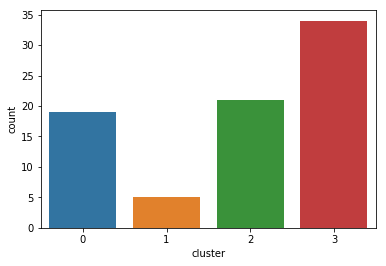

In [169]:
ax = sns.countplot(x="cluster", data=we_hella_believe)

In [170]:
brokeandfamous = data[data['name'].str.match('brokeandfamous')]
CozyThurifer = data[data['name'].str.match('CozyThurifer')]
asharnoff = data[data['name'].str.match('asharnoff')]
BrainDps = data[data['name'].str.match('BrainDps')]
LonerShaq = data[data['name'].str.match('LonerShaq')]

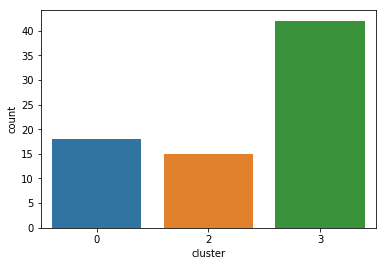

In [171]:
ax = sns.countplot(x="cluster", data=brokeandfamous)

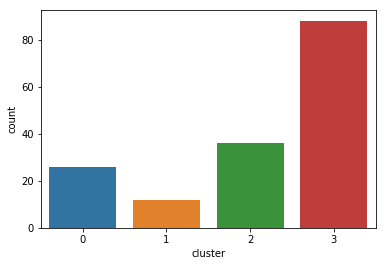

In [172]:
ax = sns.countplot(x="cluster", data=CozyThurifer)

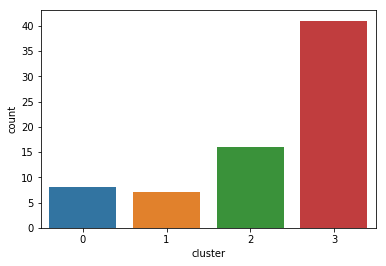

In [173]:
ax = sns.countplot(x="cluster", data=asharnoff)

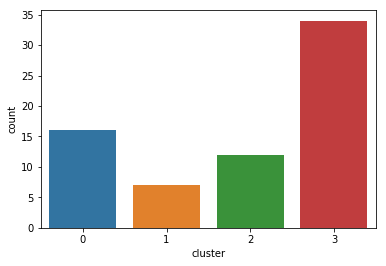

In [174]:
ax = sns.countplot(x="cluster", data=BrainDps)

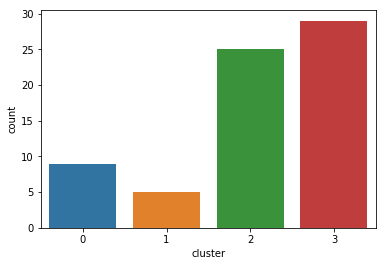

In [176]:
ax = sns.countplot(x="cluster", data=LonerShaq)
ax.